# Deep Learning
## Practice Projects
# P1: Neural Networks for Regression
In this project, we'll evaluate the performance and predictive power of neural networks in the sphere of regression tasks. Models will be trained and tested on data collected from homes in suburbs of Boston, Massachusetts.

Origin: This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

Creators: Harrison, D. and Rubinfeld, D.L.

Data Set Information: Concerns housing values in suburbs of Boston.

Attribute Information:

- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to five Boston employment centres
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per 10,000 USD
- PTRATIO: pupil-teacher ratio by town
- B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT: % lower status of the population
- MEDV: Median value of owner-occupied homes in 1000 USD

The Boston housing data was collected in 1978 and each of the 506 entries represents aggregated data about 14 features for homes from various suburbs.

## Step 0. Style and Libraries
Let's choose a style of the Jupyter notebook and import the software libraries. The command hide_code will hide the code cells.

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                       

In [1]:
hide_code = ''
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.datasets import boston_housing
from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GlobalAveragePooling1D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

Using TensorFlow backend.


In [2]:
hide_code
# Plot the Neural network fitting history
def history_plot(fit_history, n):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['mean_absolute_error'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_mean_absolute_error'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("MAE")    
    plt.legend()
    plt.title('Mean Absolute Error');

## Step 1. Load and Explore the Data
This database is very popular for studying regression and can be downloaded in several ways. Let's display the easiest ones of them.

In [3]:
hide_code
# Load the sklearn version
boston_data = datasets.load_boston()
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston_df['MEDV'] = boston_data.target

# Load the keras version
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
# Divide the test set into two subsets.
x_valid, y_valid = x_test[:51], y_test[:51]
x_test, y_test = x_test[51:], y_test[51:]

In [4]:
hide_code
# Display the example of rows
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
hide_code
# Display correlation the table
pearson = boston_df.corr(method='pearson')
corr_with_prices = pearson.iloc[-1][:-1]
# TODO: Arrange the variables in descending order of correlation (by absolute values) with the target
#       and display the results
corr_with_prices[abs(corr_with_prices).argsort()[::-1]]

LSTAT     -0.737663
RM         0.695360
PTRATIO   -0.507787
INDUS     -0.483725
TAX       -0.468536
NOX       -0.427321
CRIM      -0.385832
RAD       -0.381626
AGE       -0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: MEDV, dtype: float64

In [6]:
hide_code
# Print the shape of datasets
print ("Training feature's shape:", x_train.shape)
print ("Training target's shape", y_train.shape)
print ("Validating feature's shape:", x_valid.shape)
print ("Validating target's shape", y_valid.shape)
print ("Testing feature's shape:", x_test.shape)
print ("Testing target's shape", y_test.shape)

Training feature's shape: (404, 13)
Training target's shape (404,)
Validating feature's shape: (51, 13)
Validating target's shape (51,)
Testing feature's shape: (51, 13)
Testing target's shape (51,)


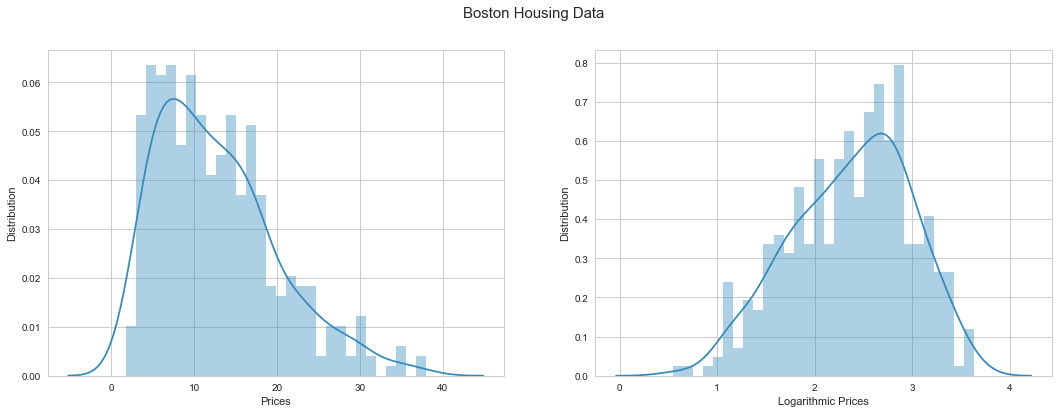

In [7]:
hide_code
# Plot the target distributions
plt.style.use('seaborn-whitegrid')
plt.figure(1, figsize=(18, 6))
plt.subplot(121)
sns.distplot(y_train, color='#348ABD', bins=30)
plt.ylabel("Distribution")
plt.xlabel("Prices")
plt.subplot(122)
sns.distplot(np.log(y_train), color='#348ABD', bins=30)
plt.ylabel("Distribution")
plt.xlabel("Logarithmic Prices")
plt.suptitle('Boston Housing Data', fontsize=15);

## Step 2. Build the Neural Networks
For more information use the following links:
- [Guide to the Sequential model](https://keras.io/getting-started/sequential-model-guide/)
- [Convolutional Neural Networks (CNNs / ConvNets)](http://cs231n.github.io/convolutional-networks/)
- [Deep Learning Resources](https://sebastianraschka.com/deep-learning-resources.html)

### Multilayer Perceptron (MLP)
Define a model architecture and compile the model.

In [8]:
hide_code
def mlp_model():
    model = Sequential()
   # TODO: Create the sequential MLP model  
    model.add(Dense(1024, activation='relu', input_dim=13))
    model.add(Dense(64, activation='relu'))        
    model.add(Dense(1, kernel_initializer='normal'))
    # TODO: Compile the model    
    model.compile(loss='mse', optimizer='nadam', metrics=['mae'])
    return model

mlp_model = mlp_model()

Run cells below to fit the model and save the best results. Choose parameters for fitting.

In [9]:
# TODO: Define parameters
epochs = 200
batch_size = 128
# Create the checkpointer for saving the best results
mlp_checkpointer = ModelCheckpoint(filepath='weights.best.mlp.hdf5', 
                                   verbose=0, save_best_only=True)
# Fit the model
mlp_history = mlp_model.fit(x_train, y_train, 
                            validation_data=(x_valid, y_valid),
                            epochs=epochs, batch_size=batch_size, verbose=0, 
                            callbacks=[mlp_checkpointer])

Display the fitting history and evaluate the model.

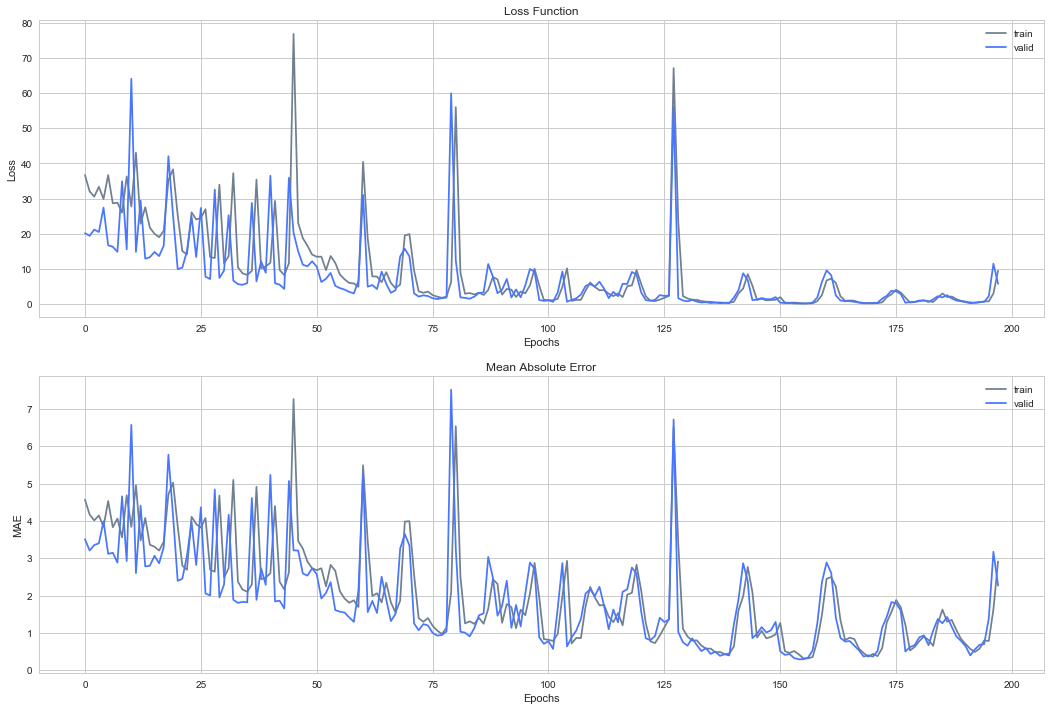

In [10]:
hide_code
# Define the starting history point
n = 2
# Display training history
history_plot(mlp_history, n)

In [11]:
hide_code
# Load the best model results 
mlp_model.load_weights('weights.best.mlp.hdf5')
# Create predictions
y_train_mlp = mlp_model.predict(x_train)
y_valid_mlp = mlp_model.predict(x_valid)
y_test_mlp = mlp_model.predict(x_test)
# Display R2 score
score_train_mlp = r2_score(y_train, y_train_mlp)
score_valid_mlp = r2_score(y_valid, y_valid_mlp)
score_test_mlp = r2_score(y_test, y_test_mlp)
print ('Train R2 score:', score_train_mlp)
print ('Valid R2 score:', score_valid_mlp)
print ('Test R2 score:', score_test_mlp)

Train R2 score: 0.996534014565
Valid R2 score: 0.996677438096
Test R2 score: 0.995773630694


### Convolutional Neural Network (CNN)

In [12]:
hide_code
def cnn_model():
    model = Sequential()
    # Create the sequential CNN model        
    model.add(Conv1D(13, 3, padding='valid', activation='relu', input_shape=(13, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(128, 3, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())  
    
    model.add(Dense(16, activation='relu', kernel_initializer='normal',))
    model.add(Dropout(0.1))
    
    model.add(Dense(1, kernel_initializer='normal'))
    # TODO: Compile the model    
    model.compile(loss='mse', optimizer='nadam', metrics=['mae'])
    return model

cnn_model = cnn_model()

Run cells below to fit the model and save the best results. Choose parameters for fitting.

In [13]:
# TODO: Define parameters
epochs = 800
batch_size = 16
# Create the checkpointer for saving the best results
cnn_checkpointer = ModelCheckpoint(filepath='weights.best.cnn.hdf5', 
                                   verbose=0, save_best_only=True)
# Fit the model
cnn_history = cnn_model.fit(x_train.reshape(-1, 13, 1), y_train, 
                            validation_data=(x_valid.reshape(-1, 13, 1), y_valid),
                            epochs=epochs, batch_size=batch_size, verbose=0, 
                            callbacks=[cnn_checkpointer])

Display the fitting history and evaluate the model.

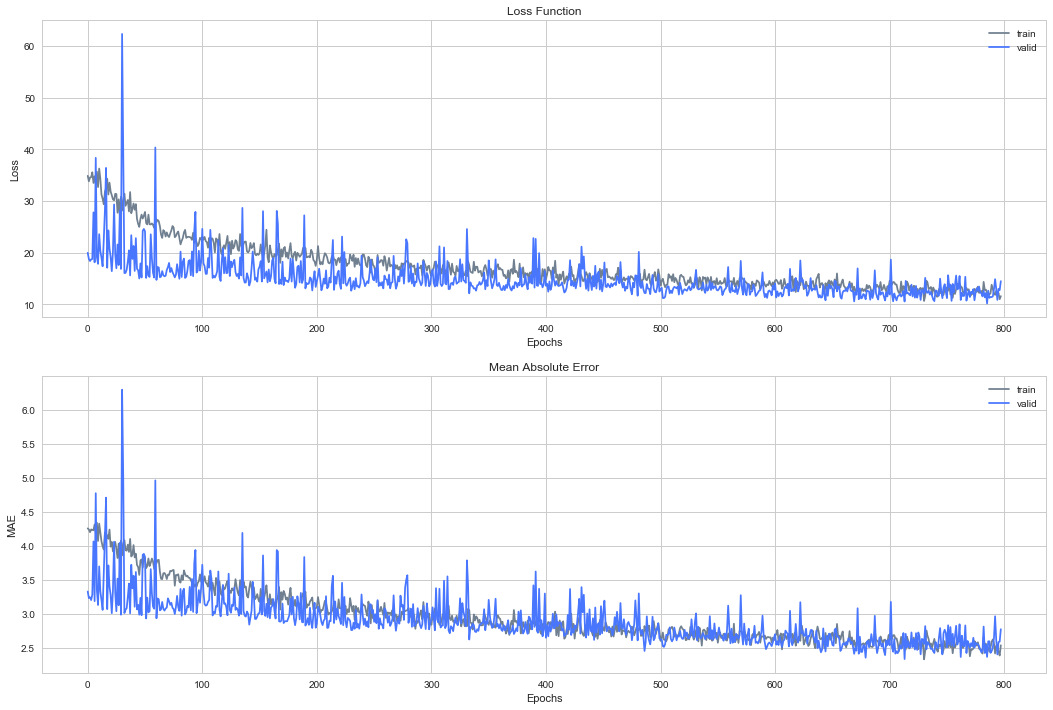

In [14]:
hide_code
# Define the starting history point
n = 2
# Display training history
history_plot(cnn_history, n)

In [15]:
hide_code
# Load the best model results 
cnn_model.load_weights('weights.best.cnn.hdf5')
# Create predictions
y_train_cnn = cnn_model.predict(x_train.reshape(-1, 13, 1))
y_valid_cnn = cnn_model.predict(x_valid.reshape(-1, 13, 1))
y_test_cnn = cnn_model.predict(x_test.reshape(-1, 13, 1))
# Display R2 score
score_train_cnn = r2_score(y_train, y_train_cnn)
score_valid_cnn = r2_score(y_valid, y_valid_cnn)
score_test_cnn = r2_score(y_test, y_test_cnn)
print ('Train R2 score:', score_train_cnn)
print ('Valid R2 score:', score_valid_cnn)
print ('Test R2 score:', score_test_cnn)

Train R2 score: 0.80985406274
Valid R2 score: 0.746580153713
Test R2 score: 0.745841703986


### Recurrent Neural Network (RNN)
Define a model architecture and compile the model.

In [16]:
hide_code
def rnn_model():
    model = Sequential()
   # TODO: Create the sequential RNN model    
    model.add(LSTM(52, return_sequences=True, input_shape=(1, 13)))
    model.add(LSTM(52, return_sequences=True))
    model.add(LSTM(52, return_sequences=False))
    
    model.add(Dense(1))
   # TODO: Compile the model
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])       
    return model 

rnn_model = rnn_model()

Run cells below to fit the model and save the best results. Choose parameters for fitting.

In [17]:
# TODO: Define parameters
epochs = 100
batch_size = 16
# Create the checkpointer for saving the best results
rnn_checkpointer = ModelCheckpoint(filepath='weights.best.rnn.hdf5', 
                                   verbose=2, save_best_only=True)
# Fit the model
rnn_history = rnn_model.fit(x_train.reshape(-1, 1, 13), y_train, 
                            validation_data=(x_valid.reshape(-1, 1, 13), y_valid),
                            epochs=epochs, batch_size=batch_size, verbose=0, 
                            callbacks=[rnn_checkpointer])

Epoch 00000: val_loss improved from inf to 147.75661, saving model to weights.best.rnn.hdf5
Epoch 00001: val_loss improved from 147.75661 to 77.77395, saving model to weights.best.rnn.hdf5
Epoch 00002: val_loss improved from 77.77395 to 48.27071, saving model to weights.best.rnn.hdf5
Epoch 00003: val_loss improved from 48.27071 to 39.82439, saving model to weights.best.rnn.hdf5
Epoch 00004: val_loss improved from 39.82439 to 33.65592, saving model to weights.best.rnn.hdf5
Epoch 00005: val_loss improved from 33.65592 to 29.71820, saving model to weights.best.rnn.hdf5
Epoch 00006: val_loss improved from 29.71820 to 25.85160, saving model to weights.best.rnn.hdf5
Epoch 00007: val_loss improved from 25.85160 to 24.49946, saving model to weights.best.rnn.hdf5
Epoch 00008: val_loss improved from 24.49946 to 24.11586, saving model to weights.best.rnn.hdf5
Epoch 00009: val_loss improved from 24.11586 to 22.02876, saving model to weights.best.rnn.hdf5
Epoch 00010: val_loss did not improve
Epoch

Display the fitting history and evaluate the model.

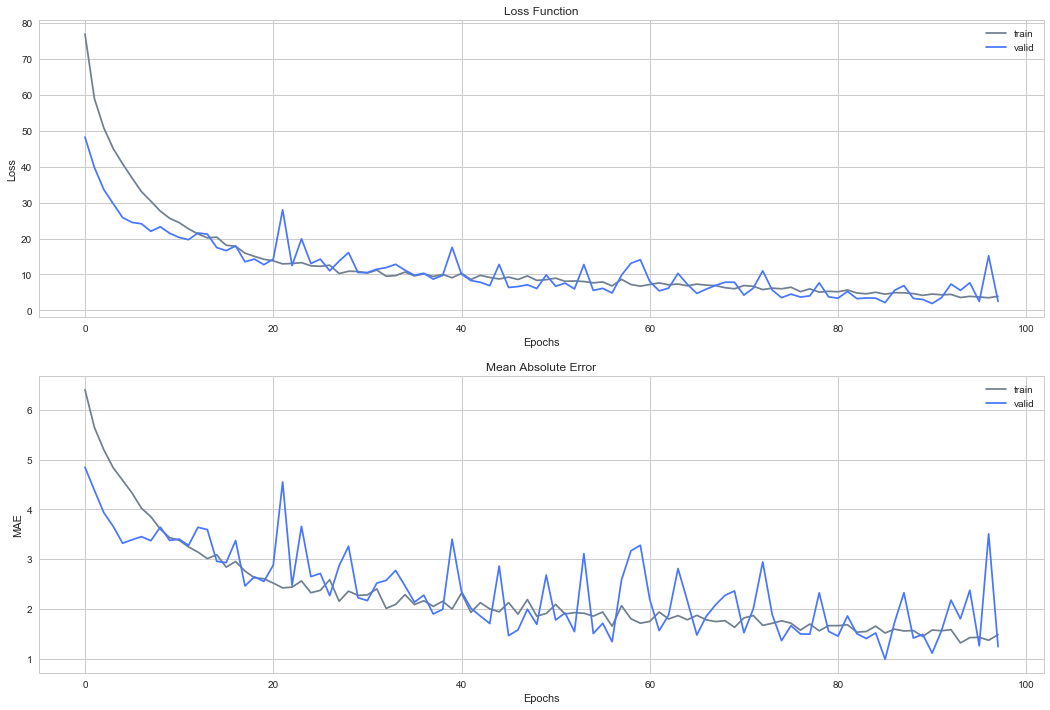

In [18]:
hide_code
# Define the starting history point
n = 2
# Display training history
history_plot(rnn_history, n)

In [19]:
hide_code
# Load the best model results 
rnn_model.load_weights('weights.best.rnn.hdf5')
# Create predictions
y_train_rnn = rnn_model.predict(x_train.reshape(-1, 1, 13))
y_valid_rnn = rnn_model.predict(x_valid.reshape(-1, 1, 13))
y_test_rnn = rnn_model.predict(x_test.reshape(-1, 1, 13))
# Display R2 score
score_train_rnn = r2_score(y_train, y_train_rnn)
score_valid_rnn = r2_score(y_valid, y_valid_rnn)
score_test_rnn = r2_score(y_test, y_test_rnn)
print ('Train R2 score:', score_train_rnn)
print ('Valid R2 score:', score_valid_rnn)
print ('Test R2 score:', score_test_rnn)

Train R2 score: 0.950343477588
Valid R2 score: 0.952736152064
Test R2 score: 0.931311459978


## Step 3. Compare Predictions
Run the cells below to visualize the quality of predictions.

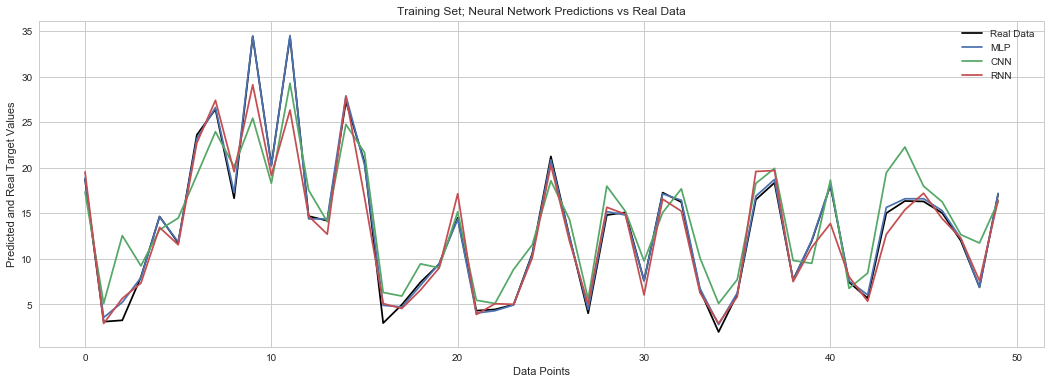

In [20]:
hide_code
# Plot predicted values and real data points
plt.figure(figsize = (18, 6))
plt.plot(y_train[:50], color = 'black', label='Real Data')

plt.plot(y_train_mlp[:50], label='MLP')
plt.plot(y_train_cnn[:50], label='CNN')
plt.plot(y_train_rnn[:50], label='RNN')

plt.xlabel("Data Points")
plt.ylabel("Predicted and Real Target Values")
plt.legend()
plt.title("Training Set; Neural Network Predictions vs Real Data");

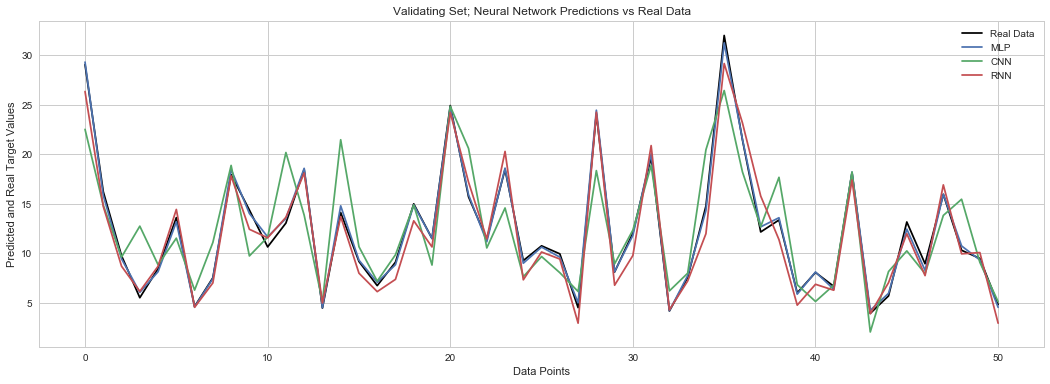

In [21]:
hide_code
# Plot predicted values and real data points
plt.figure(figsize = (18, 6))
plt.plot(y_valid, color = 'black', label='Real Data')

plt.plot(y_valid_mlp, label='MLP')
plt.plot(y_valid_cnn, label='CNN')
plt.plot(y_valid_rnn, label='RNN')

plt.xlabel("Data Points")
plt.ylabel("Predicted and Real Target Values")
plt.legend()
plt.title("Validating Set; Neural Network Predictions vs Real Data");

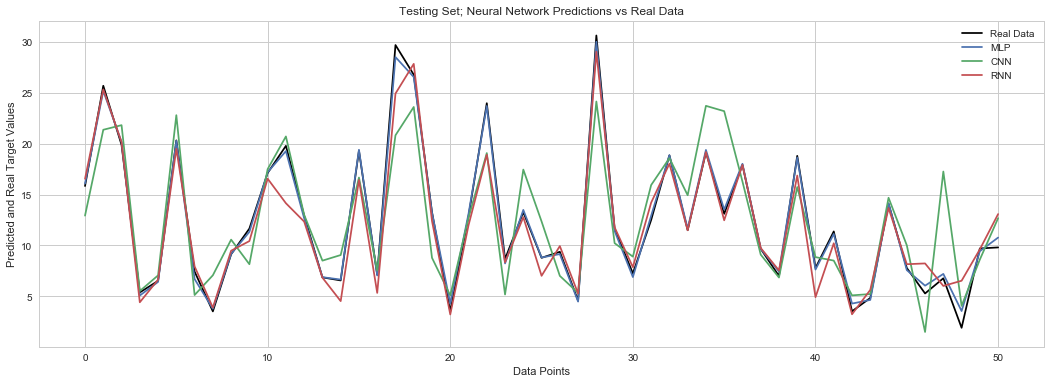

In [22]:
hide_code
# Plot predicted values and real data points
plt.figure(figsize = (18, 6))
plt.plot(y_test, color = 'black', label='Real Data')

plt.plot(y_test_mlp, label='MLP')
plt.plot(y_test_cnn, label='CNN')
plt.plot(y_test_rnn, label='RNN')

plt.xlabel("Data Points")
plt.ylabel("Predicted and Real Target Values")
plt.legend()
plt.title("Testing Set; Neural Network Predictions vs Real Data");